In [63]:
import pandas as pd

import torch
import lightning

# Эксперименты

In [64]:
# директория с данными
DATA_DIR = "../data"
# минимальное количество просмотров для трейна
MIN_VIEWS_COUNT = 20
# клип для отношения рейтинга к просмотрам, (None, None), если клип не нужен
CLIP_RATING_BY_VIEWS = (0, 1)

train_data = pd.read_json(f"{DATA_DIR}/poetry_data_train.json")

# отбрасываем объекты с маленьким количеством просмотров
print(f"filtered {round((train_data['views'] < MIN_VIEWS_COUNT).mean(), 2)} of train data")
train_data = train_data[train_data["views"] >= MIN_VIEWS_COUNT]

test_data = pd.read_json(f"{DATA_DIR}/poetry_data_test.json")

# считаем отношение рейтинга к просмотрам 
# можно будет попробовать это в экспериментах
for df in train_data, test_data:
    df["rating_by_views"] = (df["rating"] / df["views"]).clip(*CLIP_RATING_BY_VIEWS)

filtered 0.21 of train data


<Axes: title={'center': 'distribution of `rating_by_views`'}, ylabel='Frequency'>

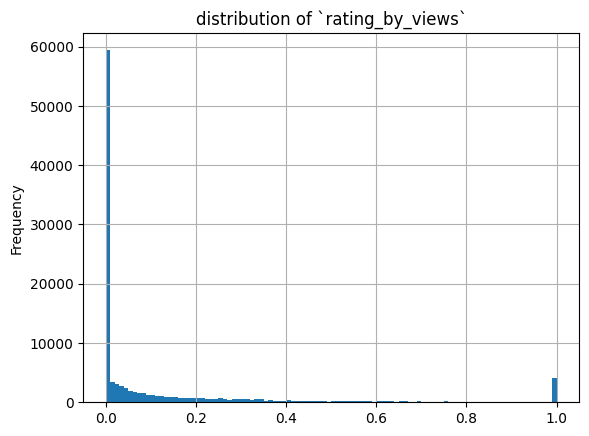

In [65]:
train_data["rating_by_views"].plot(kind="hist", bins=100, grid=True, title="distribution of `rating_by_views`")

## Метрики

In [66]:
from torchmetrics.retrieval import RetrievalNormalizedDCG, RetrievalPrecision
from torchmetrics.regression import MeanSquaredError

## Обучение

### Регрессия

In [102]:
from sklearn.calibration import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Sampler
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import random_split
import numpy as np

class RegressionDataset(Dataset):

    def __init__(
            self,
            df: pd.DataFrame,
            tokenizer: AutoTokenizer,
            max_length: int = 512,
            target_expr: str | None = None,
            extra_keys: tuple[str, ...] = tuple(),
        ):
        super().__init__()
        self._df = df
        self._tokenizer = tokenizer
        self._target_expr = target_expr
        self._extra_keys = extra_keys
        self._max_length = max_length

    def __len__(self) -> int:
        return len(self._df)

    def __getitem__(self, idx: int) -> dict:
        row = self._df.iloc[idx]

        text = row["output_text"]
        tokenizer_out = self._tokenizer(text, padding="max_length", truncation=True, max_length=self._max_length, return_tensors='pt', )

        if self._target_expr:
            target = eval(self._target_expr, {**row.to_dict(), "np": np})
        else:
            target = row["rating"]

        return {
            "input_ids": tokenizer_out["input_ids"],
            "attention_mask": tokenizer_out["attention_mask"],
            "target": torch.tensor(target, dtype=torch.float32),
            **{
                key: row[key] for key in self._extra_keys
            }
        }

class RegressionDataModule(lightning.LightningDataModule):
    
    def __init__(
        self,
        dataset: RegressionDataset,
        val_size: float = 0.2,
        batch_size: int = 8,
        sampler_type: str | None = None,
    ):
        super().__init__()
        val_size = int(len(dataset) * val_size)
        train_size = len(dataset) - val_size

        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])
        self.batch_size = batch_size

        # 1 вариант: берем нулевые объекты с меньшим весом
        if sampler_type == "zero_ratings":
            sampler = WeightedRandomSampler(
                np.where(self.train_dataset.dataset._df["rating"].iloc[self.train_dataset.indices].values == 0, 0.1, 0.9),
                num_samples=train_size,
                replacement=True,
            )
        elif sampler_type == "new2":
            train_data = self.train_dataset.dataset._df.iloc[self.train_dataset.indices, :]
    
            rating_weights = train_data["rating"].rank(method="dense") / train_data["rating"].rank(method="dense").max()
            views_weights = train_data["views"].rank(method="dense") / train_data["views"].rank(method="dense").max()

            union_weights = (0.4 * views_weights + 0.6 * rating_weights).values
            sampler = WeightedRandomSampler(
                union_weights,
                num_samples=train_size,
                replacement=True,
            )
        else:
            sampler = None
        
        self.dataloader_kwargs = {"shuffle": True}
        if sampler is not None:
            del self.dataloader_kwargs["shuffle"]
            self.dataloader_kwargs["sampler"] = sampler

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, **self.dataloader_kwargs, )
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size,)
    
    def transfer_batch_to_device(self, batch, device, dataloader_idx):
        extra_batch = {}
        for key in self.train_dataset.dataset._extra_keys:
            extra_batch[key] = batch.pop(key)
        extra_batch.update(super().transfer_batch_to_device(batch, device, dataloader_idx))
        return extra_batch


class RegressionModule(lightning.LightningModule):

    def __init__(self, model: AutoModel, n_epochs: int, freeze: bool = True, lr: float = 0.0001):
        super().__init__()
        self.lr = lr
        self.n_epochs = n_epochs

        self.model = model
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(768, 256),
            torch.nn.Sigmoid(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 1),
        )

        self.ndcg = RetrievalNormalizedDCG()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler
            },
        }
    
    def forward(self, input_ids, attention_mask):
        x = self.model(input_ids=input_ids, attention_mask=attention_mask)
        x = self.fc(x.pooler_output)
        return x
    
    def training_step(self, batch: dict, **_):
  
        input_ids = batch["input_ids"].reshape(batch["input_ids"].shape[0], batch["input_ids"].shape[-1])
        attention_mask = batch["attention_mask"]

        out = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = torch.nn.functional.mse_loss(out.squeeze(), batch["target"].squeeze())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        ndcg_score = self.ndcg(out.squeeze(), batch["target"].squeeze(), indexes=torch.from_numpy(LabelEncoder().fit_transform(batch["genre"])))
        self.log("train_ndcg", ndcg_score, on_step=True, on_epoch=True, prog_bar=True)

        return loss
    
    def validation_step(self, batch: dict, **_):
                
        input_ids = batch["input_ids"].reshape(batch["input_ids"].shape[0], batch["input_ids"].shape[-1])
        attention_mask = batch["attention_mask"]

        out = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = torch.nn.functional.mse_loss(out.squeeze(), batch["target"].squeeze())
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        ndcg_score = self.ndcg(out, batch["target"], indexes=LabelEncoder().transform(batch["genre"]))
        self.log("val_ndcg", ndcg_score, on_step=True, on_epoch=True, prog_bar=True)

        return loss

In [103]:
# %%capture
n_epochs = 10

tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
model.train()

dataset = RegressionDataset(df=train_data, tokenizer=tokenizer, target_expr="rating / views", extra_keys=("genre", ))

datamodule = RegressionDataModule(dataset=dataset, batch_size=32, val_size=0.1, sampler_type="new2")
module = RegressionModule(model=model, n_epochs=n_epochs, freeze=True)

In [104]:
import tensorboard

In [105]:
# ! ls ~/.cache/huggingface/hub

In [106]:
trainer = lightning.Trainer(
    logger=lightning.pytorch.loggers.TensorBoardLogger("./"),
    max_epochs=n_epochs,
    val_check_interval=500,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=True,
    enable_model_summary=True,
    num_sanity_val_steps=0,
)

trainer.fit(model=module, datamodule=datamodule)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | BertModel              | 128 M  | train
1 | fc    | Sequential             | 197 K  | train
2 | ndcg  | RetrievalNormalizedDCG | 0      | train
---------------------------------------------------------
197 K     Trainable params
128 M     Non-trainable params
128 M     Total params
514.171   Total estimated model params size (MB)
234       Modules in train mode
0         Modules in eval mode
/Users/vyacheslav.kostrov/my/hse-mlds/subjects/deep-learning-1/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [107]:
onegin_sample = """Мой дядя самых честных правил,
Когда не в шутку занемог,
Он уважать себя заставил
И лучше выдумать не мог.
Его пример другим наука;
Но, боже мой, какая скука
С больным сидеть и день и ночь,
Не отходя ни шагу прочь!
Какое низкое коварство
Полуживого забавлять,
Ему подушки поправлять,
Печально подносить лекарство,
Вздыхать и думать про себя:
Когда же черт возьмет тебя!
"""

In [126]:
module.eval()
tokenized_onegin_sample = tokenizer(onegin_sample, padding="max_length", truncation=True, max_length=512, return_tensors='pt')
model_score = module(input_ids=tokenized_onegin_sample.input_ids, attention_mask=tokenized_onegin_sample.attention_mask)
model_score

tensor([[0.2373]], grad_fn=<AddmmBackward0>)

In [127]:
# bad_samples = test_data.query("rating < 5 and views > 5000").output_text.values

# for bad_sample in bad_samples:
#     tokenized_bad_sample = tokenizer(bad_sample, padding="max_length", truncation=True, max_length=512, return_tensors='pt')
#     model_score = module(input_ids=tokenized_bad_sample.input_ids, attention_mask=tokenized_bad_sample.attention_mask)
#     print(model_score)
    

In [128]:
# for good_sample in test_data.query("rating > 400 and views > 1000").output_text.values:
#     tokenized_good_sample = tokenizer(good_sample, padding="max_length", truncation=True, max_length=512, return_tensors='pt')
#     model_score = module(input_ids=tokenized_good_sample.input_ids, attention_mask=tokenized_good_sample.attention_mask)
#     print(model_score)

# классификация

In [10]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Sampler
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import random_split
import numpy as np

class ClassificationDataset(Dataset):

    def __init__(
            self,
            df: pd.DataFrame,
            tokenizer: AutoTokenizer,
            max_length: int = 512,
            target_expr: str | None = None,
            extra_keys: tuple[str, ...] = tuple(),
        ):
        super().__init__()
        self._df = df
        self._tokenizer = tokenizer
        self._target_expr = target_expr
        self._extra_keys = extra_keys
        self._max_length = max_length

    def __len__(self) -> int:
        return len(self._df)

    def __getitem__(self, idx: int) -> dict:
        row = self._df.iloc[idx]

        text = row["output_text"]
        tokenizer_out = self._tokenizer(text, padding="max_length", truncation=True, max_length=self._max_length, return_tensors='pt', )

        if self._target_expr:
            target = eval(self._target_expr, {**row.to_dict(), "np": np})
        else:
            target = row["rating"] > 0

        return {
            "input_ids": tokenizer_out["input_ids"],
            "attention_mask": tokenizer_out["attention_mask"],
            "target": torch.tensor(target, dtype=torch.long),
            **{
                key: row[key] for key in self._extra_keys
            }
        }

class ClassificationDataModule(lightning.LightningDataModule):
    
    def __init__(
        self,
        dataset: ClassificationDataset,
        val_size: float = 0.2,
        batch_size: int = 8,
        sampler_type: str | None = None,
    ):
        super().__init__()
        val_size = int(len(dataset) * val_size)
        train_size = len(dataset) - val_size

        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])
        self.batch_size = batch_size

        # 1 вариант: берем нулевые объекты с меньшим весом
        if sampler_type == "zero_ratings":
            sampler = WeightedRandomSampler(
                np.where(self.train_dataset.dataset._df["rating"].iloc[self.train_dataset.indices].values == 0, 0.1, 0.9),
                num_samples=train_size,
                replacement=True,
            )
        elif sampler_type == "new2":
            train_data = self.train_dataset.dataset._df.iloc[self.train_dataset.indices, :]
    
            rating_weights = train_data["rating"].rank(method="dense") / train_data["rating"].rank(method="dense").max()
            views_weights = train_data["views"].rank(method="dense") / train_data["views"].rank(method="dense").max()

            union_weights = (0.4 * views_weights + 0.6 * rating_weights)
            sampler = WeightedRandomSampler(
                union_weights,
                num_samples=train_size,
                replacement=True,
            )
        else:
            sampler = None
        
        self.dataloader_kwargs = {"shuffle": True}
        if sampler is not None:
            del self.dataloader_kwargs["shuffle"]
            self.dataloader_kwargs["sampler"] = sampler

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, **self.dataloader_kwargs, )
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size,)


class ClassificationModule(lightning.LightningModule):

    def __init__(self, model: AutoModel, n_epochs: int, freeze: bool = True, lr: float = 0.0001):
        super().__init__()
        self.lr = lr
        self.n_epochs = n_epochs

        self.model = model
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(312, 256),
            torch.nn.Sigmoid(),
            # torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid(),
        )

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler
            },
        }
    
    def forward(self, input_ids, attention_mask):
        x = self.model(input_ids=input_ids, attention_mask=attention_mask)
        x = self.fc(x.pooler_output)
        return x
    
    def training_step(self, batch: dict, **_):
  
        input_ids = batch["input_ids"].reshape(batch["input_ids"].shape[0], batch["input_ids"].shape[-1])
        attention_mask = batch["attention_mask"]

        out = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = torch.nn.BCELoss()(out.squeeze(), batch["target"].float())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss
    
    def validation_step(self, batch: dict, **_):
                
        input_ids = batch["input_ids"].reshape(batch["input_ids"].shape[0], batch["input_ids"].shape[-1])
        attention_mask = batch["attention_mask"]

        out = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = torch.nn.BCELoss()(out.squeeze(), batch["target"].float())
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

In [11]:
%%capture
n_epochs = 10

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
dataset = ClassificationDataset(df=train_data, tokenizer=tokenizer, target_expr="rating > 3",)

datamodule = ClassificationDataModule(dataset=dataset, batch_size=32, val_size=0.1, sampler_type=None)
module = ClassificationModule(model=model, n_epochs=n_epochs, freeze=True)

In [12]:
train_data.rating.values[0]

29

In [13]:
trainer = lightning.Trainer(
    logger=lightning.pytorch.loggers.TensorBoardLogger("./"),
    max_epochs=n_epochs,
    val_check_interval=500,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=True,
    enable_model_summary=True,
    num_sanity_val_steps=0,
)

trainer.fit(model=module, datamodule=datamodule)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | BertModel  | 11.8 M | eval 
1 | fc    | Sequential | 80.4 K | train
---------------------------------------------
80.4 K    Trainable params
11.8 M    Non-trainable params
11.9 M    Total params
47.458    Total estimated model params size (MB)
5         Modules in train mode
66        Modules in eval mode
/Users/vyacheslav.kostrov/my/hse-mlds/subjects/deep-learning-1/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/vyacheslav.kostrov/my/hse-mlds/subjects/deep-learning-1/.conda/lib/python3.11/site-packages/lightning/pytorch/t

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# bi encoder

In [66]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

bi_encoder = SentenceTransformer('distiluse-base-multilingual-cased-v1', device="mps")  #('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256  
top_k = 32                          

cross_encoder = CrossEncoder('DiTy/cross-encoder-russian-msmarco', device="mps")

passages = train_data.output_text.values.tolist()
print("Passages:", len(passages))

corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)


/Users/vyacheslav.kostrov/my/hse-mlds/subjects/deep-learning-1/.conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Passages: 109556


Batches:   0%|          | 0/3424 [00:00<?, ?it/s]

In [67]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import numpy as np


def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc


tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

  0%|          | 0/109556 [00:00<?, ?it/s]

In [70]:
# This function will search all wikipedia articles for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-3 lexical search (BM25) hits")
    for hit in bm25_hits[0:3]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Semantic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.to("mps") #.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-3 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:3]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-3 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:3]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))


In [72]:
search(query = "Выведи лучшее стихотворение")

Input question: Выведи лучшее стихотворение
Top-3 lexical search (BM25) hits
	13.605	Сяду в автобус, в любом направлении, От суеты в тишину убегу - Вдруг да напишется стихотворение, Там, где околицы тонут в снегу!  Там после сна предрассветного, длинного, Радуя новым восходом страну, Солнце морозное встало малиново, Чтобы окрасить снегов белизну.  И, поднимая моё настроение, Сердцу быстрее забиться велит! Так вот и пишется стихотворение - Буква за буквой, и весь алфавит!  Я, напрягая уставшее зрение, Стану с собой, молодым, наравне... Так вот и пишется стихотворение - Дымом по ветру, морозом в окне.  Сразу забуду про возраст свой древний я, Буду любовь воспевать и добро! Так вот и пишется стихотворение - Инеем в бороду,
	13.371	Цветёт сирень неистово Пахучая, прохладная. С ветвей росинки чистые В ладонь мне тихо падают. Я в день иду сиреневый, Иду не настороженно, Ищу стихотворение - Весеннее, хорошее. Моё стихотворение, Оно пока не встречено, Но этим днём сиреневым До жилочек просвече

In [73]:
search(query = "Стихотворение про осень")

Input question: Стихотворение про осень
Top-3 lexical search (BM25) hits
	16.485	Сяду в автобус, в любом направлении, От суеты в тишину убегу - Вдруг да напишется стихотворение, Там, где околицы тонут в снегу!  Там после сна предрассветного, длинного, Радуя новым восходом страну, Солнце морозное встало малиново, Чтобы окрасить снегов белизну.  И, поднимая моё настроение, Сердцу быстрее забиться велит! Так вот и пишется стихотворение - Буква за буквой, и весь алфавит!  Я, напрягая уставшее зрение, Стану с собой, молодым, наравне... Так вот и пишется стихотворение - Дымом по ветру, морозом в окне.  Сразу забуду про возраст свой древний я, Буду любовь воспевать и добро! Так вот и пишется стихотворение - Инеем в бороду,
	14.155	Хочешь, подарю настроение Сочиню для тебя стихотворение Не знаю, правда, пока про что Но точно будет оно с добром Наивно, смешно, пускай порой Зато от души, и сердца строкой  Читая его, улыбнёшься Настроения наберёшься Этого я добиваюсь Печали твои прогоняя
	13.416	

In [62]:
# TODO: попробвать как-то адаптировать, "из коробки" скорее поиск по тематике получается